In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [ ]:
df = pd.read_csv("ML_DATASET.csv")

In [3]:
df['previous_year_rating'].fillna(df['previous_year_rating'].median(), inplace=True)
df['education'].fillna('Unknown', inplace=True)
df.drop(columns=['employee_id'], inplace=True)
df=df.dropna(subset=['KPIs_met_more_than_80'])

C:\Users\raghu\AppData\Local\Temp\ipykernel_8592\296086559.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['previous_year_rating'].fillna(df['previous_year_rating'].median(), inplace=True)
C:\Users\raghu\AppData\Local\Temp\ipykernel_8592\296086559.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

In [4]:
df_encoded = df.copy()

In [ ]:
X = df_encoded.drop(columns=['KPIs_met_more_than_80'])
y = df_encoded['KPIs_met_more_than_80']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import TargetEncoder

class TargetEncoderWrapper(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder = TargetEncoder()

    def fit(self, X, y):
        self.encoder.fit(X, y)
        return self

    def transform(self, X):
        return self.encoder.transform(X)

In [ ]:
from sklearn.preprocessing import LabelEncoder, TargetEncoder

cat_attribs = ['department', 'recruitment_channel']
label_cols = ['gender', 'education']
target_encode_col = ['region']

In [ ]:
num_attribs = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_attribs = list(set(num_attribs) - set(label_cols) - set(['region_encoded']))

full_preprocessing = ColumnTransformer([
    ('target_encode', TargetEncoderWrapper(), target_encode_col),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_attribs),
    ('num', StandardScaler(), num_attribs + label_cols)
])

In [ ]:
tree_pipeline = Pipeline([
    ('preprocessing', full_preprocessing),
    ('tree_clf', DecisionTreeClassifier(random_state=42))
])

param_grid = {'tree_clf__max_depth': np.arange(2, 21)}

grid_search = GridSearchCV(
    estimator=tree_pipeline,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    verbose=1,
    return_train_score=True,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

best_dt_model = grid_search.best_estimator_

y_pred = best_dt_model.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 19 candidates, totalling 95 fits
Best Parameters: {'tree_clf__max_depth': np.int64(5)}
Best F1 Score: 0.6468274298365996
Confusion Matrix:
 [[1983  251]
 [ 779  471]]

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.89      0.79      2234
           1       0.65      0.38      0.48      1250

    accuracy                           0.70      3484
   macro avg       0.69      0.63      0.64      3484
weighted avg       0.69      0.70      0.68      3484



In [9]:
rf_pipeline = Pipeline([
    ('preprocessing', full_preprocessing),
    ('rf_clf', RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    'rf_clf__n_estimators': [50, 100],         
    'rf_clf__max_depth': [5, 10, 15],         
    'rf_clf__min_samples_split': [2, 5]       
}

grid_search_rf = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid_rf,
    scoring='f1_macro',
    cv=5,
    verbose=1,
    return_train_score=True,
    n_jobs=-1
)

grid_search_rf.fit(X_train, y_train)

print("Best Parameters (Random Forest):", grid_search_rf.best_params_)
print("Best F1 Score (Random Forest):", grid_search_rf.best_score_)

best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)

print("\nConfusion Matrix (Random Forest):\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report (Random Forest):\n", classification_report(y_test, y_pred_rf))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters (Random Forest): {'rf_clf__max_depth': 15, 'rf_clf__min_samples_split': 2, 'rf_clf__n_estimators': 100}
Best F1 Score (Random Forest): 0.6503457789104842

Confusion Matrix (Random Forest):
 [[1949  285]
 [ 745  505]]

Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       0.72      0.87      0.79      2234
           1       0.64      0.40      0.50      1250

    accuracy                           0.70      3484
   macro avg       0.68      0.64      0.64      3484
weighted avg       0.69      0.70      0.68      3484



In [ ]:
svm_pipeline = Pipeline([
    ('preprocessing', full_preprocessing),
    ('svm_clf', SVC(probability=True, random_state=42))
])

param_grid_svm = {
    'svm_clf__C': [0.1, 1, 10,100],      
    'svm_clf__kernel': ['rbf', 'linear'], 
    'svm_clf__gamma': [0.001, 0.01, 0.1, 1, 100]   
}

grid_search_svm = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid_svm,
    scoring='f1_macro',
    cv=5,
    verbose=1,
    return_train_score=True,
    n_jobs=-1
)

grid_search_svm.fit(X_train, y_train)

print(" Best Parameters (SVM):", grid_search_svm.best_params_)
print(" Best F1 Score (SVM):", grid_search_svm.best_score_)

best_svm_model = grid_search_svm.best_estimator_
y_pred_svm = best_svm_model.predict(X_test)

print("\n Confusion Matrix (SVM):\n", confusion_matrix(y_test, y_pred_svm))
print("\n Classification Report (SVM):\n", classification_report(y_test, y_pred_svm))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
 Best Parameters (SVM): {'svm_clf__C': 0.1, 'svm_clf__gamma': 'scale', 'svm_clf__kernel': 'linear'}
 Best F1 Score (SVM): 0.6618665137552524

 Confusion Matrix (SVM):
 [[1769  465]
 [ 623  627]]

 Classification Report (SVM):
               precision    recall  f1-score   support

           0       0.74      0.79      0.76      2234
           1       0.57      0.50      0.54      1250

    accuracy                           0.69      3484
   macro avg       0.66      0.65      0.65      3484
weighted avg       0.68      0.69      0.68      3484



In [11]:
logreg_pipeline = Pipeline([
    ('preprocessing', full_preprocessing),
    ('logreg_clf', LogisticRegression(solver='liblinear', random_state=42))
])

param_grid_logreg = {
    'logreg_clf__C': [0.01, 0.1, 1, 10, 100],  
    'logreg_clf__penalty': ['l1', 'l2']       
}

grid_search_logreg = GridSearchCV(
    estimator=logreg_pipeline,
    param_grid=param_grid_logreg,
    scoring='f1_macro',
    cv=5,
    verbose=1,
    return_train_score=True,
    n_jobs=-1
)

grid_search_logreg.fit(X_train, y_train)

print("Best Parameters (Logistic Regression):", grid_search_logreg.best_params_)
print("Best F1 Score (Logistic Regression):", grid_search_logreg.best_score_)

best_log_model = grid_search_logreg.best_estimator_
y_pred_logreg = best_log_model.predict(X_test)

print("\n Confusion Matrix (Logistic Regression):\n", confusion_matrix(y_test, y_pred_logreg))
print("\n Classification Report (Logistic Regression):\n", classification_report(y_test, y_pred_logreg))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters (Logistic Regression): {'logreg_clf__C': 0.1, 'logreg_clf__penalty': 'l2'}
Best F1 Score (Logistic Regression): 0.6516542262810885

 Confusion Matrix (Logistic Regression):
 [[1891  343]
 [ 722  528]]

 Classification Report (Logistic Regression):
               precision    recall  f1-score   support

           0       0.72      0.85      0.78      2234
           1       0.61      0.42      0.50      1250

    accuracy                           0.69      3484
   macro avg       0.66      0.63      0.64      3484
weighted avg       0.68      0.69      0.68      3484



In [15]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

models = {
    "Logistic Regression": best_log_model,
    "Random Forest": best_rf_model,
    "Decision Tree": best_dt_model,
    "SVM": best_svm_model
}

metrics = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    metrics.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    })

metrics_df = pd.DataFrame(metrics)
print(" Model Comparison:")
display(metrics_df.style.set_caption("Model Evaluation Metrics").format({
    "Accuracy": "{:.2%}",
    "Precision": "{:.2%}",
    "Recall": "{:.2%}",
    "F1 Score": "{:.2%}"
}))

 Model Comparison:


,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,69.43%,60.62%,42.24%,49.79%
1,Random Forest,70.44%,63.92%,40.40%,49.51%
2,Decision Tree,70.44%,65.24%,37.68%,47.77%
3,SVM,68.77%,57.42%,50.16%,53.54%


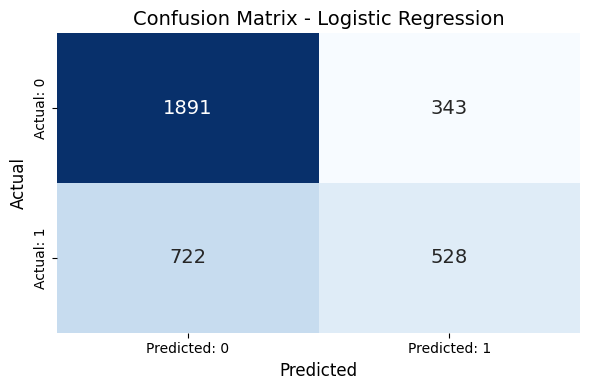

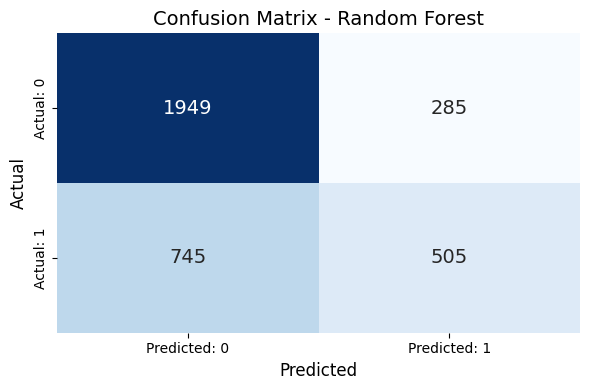

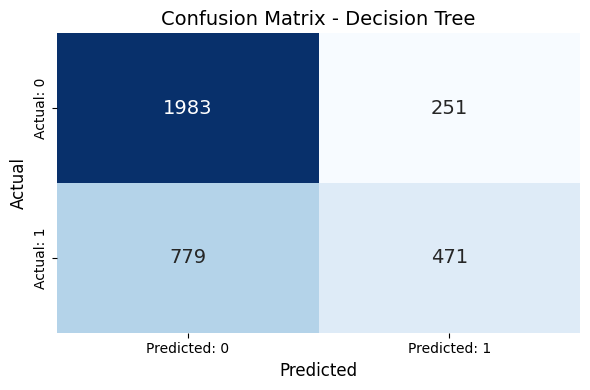

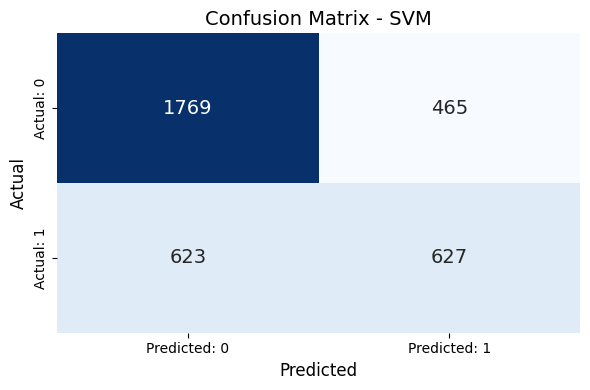

In [16]:
def plot_confusion_matrix(model, y_test, X_test, title):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=['Actual: 0', 'Actual: 1'], columns=['Predicted: 0', 'Predicted: 1'])

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14})
    plt.title(f"Confusion Matrix - {title}", fontsize=14)
    plt.ylabel('Actual', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

for name, model in models.items():
    plot_confusion_matrix(model, y_test, X_test, name)

In [18]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

proba_dict = {
    "Logistic Regression": best_log_model.predict_proba(X_test)[:, 1],
    "Random Forest": best_rf_model.predict_proba(X_test)[:, 1],
    "Decision Tree": best_dt_model.predict_proba(X_test)[:, 1],
    "SVM": best_svm_model.decision_function(X_test)
}

def plot_combined_roc(y_test, proba_dict):
    """
    y_test: Ground truth labels
    proba_dict: Dictionary of model name to predicted probabilities or scores
    """
    plt.figure(figsize=(10, 7))

    for model_name, y_score in proba_dict.items():
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(' Combined ROC Curves - Performance Classification', fontsize=16)
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

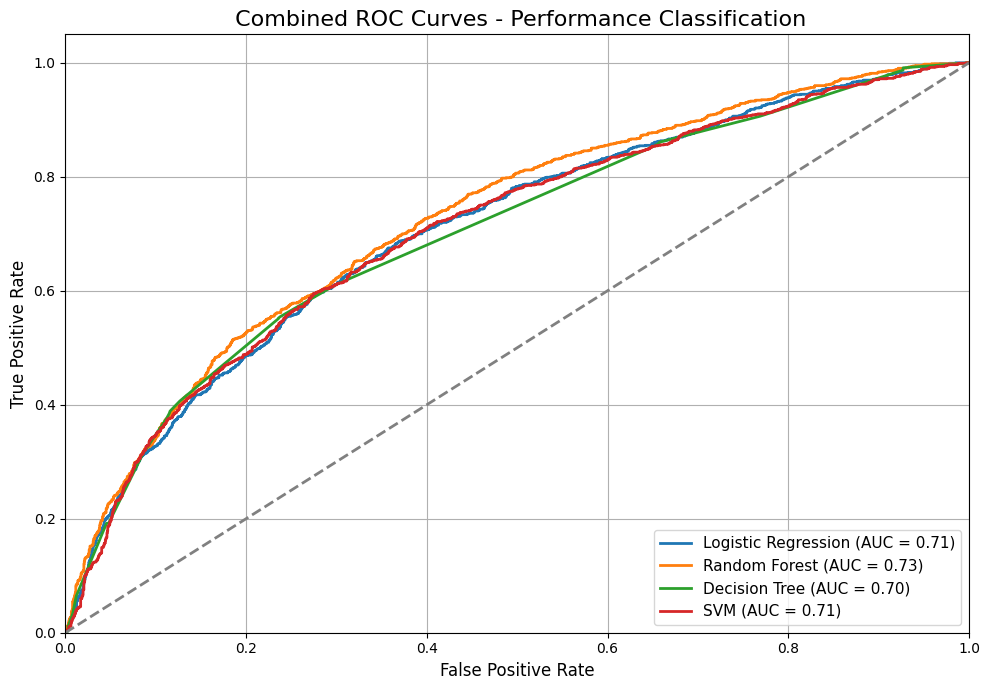

In [ ]:
plot_combined_roc(y_test, proba_dict)